# ASE & CP2K

Set some environment variables for the notebook. For doing this on a HPC resource, these would be set as export commands in the slurm script. Also, the ASE_CP2K_COMMAND would change to "srun cp2k_shell.psmp"

In [2]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=8
%set_env VECLIB_MAXIMUM_THREADS=1
%set_env ASE_CP2K_COMMAND=cp2k_shell.ssmp

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=8
env: VECLIB_MAXIMUM_THREADS=1
env: ASE_CP2K_COMMAND=cp2k_shell.ssmp


## Modules

In [3]:
# General
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

# For building things
from ase import Atom, Atoms
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.build import molecule, surface, add_adsorbate, add_vacuum, sort
from ase.visualize import view
from ase.db import connect
from ase.geometry import get_layers
import nglview as nv

# Unit Conversions and Fixing Atoms
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.constraints import FixedPlane, FixedLine, FixAtoms

# ASE Calculators
from plumed import Plumed
from ase.calculators.cp2k import CP2K
from ase.calculators.lj import LennardJones
from ase.calculators.plumed import Plumed
from ase.calculators.idealgas import IdealGas

# Geometry Optimizations and Normal Mode Analysis
from ase.optimize import LBFGS, FIRE
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo

# EOS fitting for Unit Cells
from ase.eos import EquationOfState, calculate_eos

# Molecular Dynamics
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.npt import NPT

cwd = os.getcwd()
cwd

'/home/woodrowwilson/Documents/Projects/MSELProjects/NSF/SurfacesAndBulk'

In [128]:
def myCP2KCalculator_v2(ecut, functional="LDA", kpoints=None, dipole_correction=False, orbital_transform=False,smearing=False):
    """Creates a CP2K calculator object with Settings for Production Runs
    tag -> label for cp2k output
    functional -> Either PBE+D3, BEEFVDW, rVV10, or LDA+FermiDirac
    ecut -> PW Kinetic Energy Cutoff (Rydberg)
    """
    
    # By Default, assume we want to have the walltime as just shy of 48 hours
    inp = '''
&GLOBAL
WALLTIME 47:59:00
&END GLOBAL
&FORCE_EVAL
&DFT
'''
    
    ### DFT SECTION
    if dipole_correction:
        inp += '''
SURFACE_DIPOLE_CORRECTION .TRUE.
SURF_DIP_DIR Z  
'''
    if kpoints is not None:

        s = "SCHEME MONKHORST-PACK " + str(kpoints[0]) + " " + str(kpoints[1]) + " " + str(kpoints[2]) + "\n"
        inp += '''
&KPOINTS
'''
        inp += s
        inp += '''
&END KPOINTS
'''      
    
    ### SCF SECTION
    inp += '''
&SCF
&OUTER_SCF .TRUE.
MAX_SCF 50
&END OUTER_SCF
'''
    
    if orbital_transform:
        inp +='''
&OT .TRUE.
MINIMIZER DIIS
PRECONDITIONER FULL_SINGLE_INVERSE
&END OT
'''
        
    if smearing:
        inp +='''
ADDED_MOS 10
&SMEAR ON
METHOD FERMI_DIRAC
ELECTRONIC_TEMPERATURE [K] 300
&END SMEAR
&MIXING .TRUE.
METHOD BROYDEN_MIXING
&END MIXING
'''
        

    ###CLOSE SCF SECTION
    inp += '''
&END SCF
    '''
    
    ### XC Section
    inp += '''
&XC
&XC_GRID
XC_DERIV NN10_SMOOTH
XC_SMOOTH_RHO NN10
&END
'''
    
    if functional == "PBE+D3":
        functional="PBE"
        inp += '''
''''''
&VDW_POTENTIAL
POTENTIAL_TYPE PAIR_POTENTIAL
&PAIR_POTENTIAL
R_CUTOFF 15.0
TYPE DFTD3
VERBOSE_OUTPUT
CALCULATE_C9_TERM .FALSE.
REFERENCE_FUNCTIONAL PBE
PARAMETER_FILE_NAME dftd3.dat
&END PAIR_POTENTIAL
&END VDW_POTENTIAL
'''
        
    if functional == "optB88-vdw":
        functional = None
        inp += '''
&XC_FUNCTIONAL
&LIBXC
FUNCTIONAL GGA_X_OPTB88_VDW
&END LIBXC
&PW92
&END PW92
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE DRSLL
VERBOSE_OUTPUT
KERNEL_FILE_NAME vdW_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL
'''
        
    if functional == "optB86B-vdw":
        functional = None
        inp += '''
&XC_FUNCTIONAL
&LIBXC
FUNCTIONAL GGA_X_OPTB86B_VDW
&END LIBXC
&PW92
&END PW92
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE DRSLL
VERBOSE_OUTPUT
KERNEL_FILE_NAME vdW_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL
'''
    if functional == "optPBE-vdw":
        functional = None
        inp += '''
&XC_FUNCTIONAL
&LIBXC
FUNCTIONAL GGA_X_OPTPBE_VDW
&END LIBXC
&PW92
&END PW92
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE DRSLL
VERBOSE_OUTPUT
KERNEL_FILE_NAME vdW_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL
'''
      
    if functional == "rVV10":
        functional = None
        inp += '''
&XC_FUNCTIONAL
&GGA_X_RPW86
&END GGA_X_RPW86
&GGA_C_PBE
&END GGA_C_PBE
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE RVV10
VERBOSE_OUTPUT
KERNEL_FILE_NAME rVV10_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL
'''
          

    ### CLOSE EVERYTHING OFF
    inp += '''
&END XC
&END DFT
&END FORCE_EVAL
'''
        
    calc = CP2K(
        auto_write=False,
        basis_set="DZVP-MOLOPT-SR-GTH",
        basis_set_file="BASIS_MOLOPT",
        charge=0,
        cutoff = ecut*Rydberg,
        debug = False,
        force_eval_method = "Quickstep",
        xc = functional,
        inp = inp,
        max_scf = 50,
        poisson_solver ="auto",
        potential_file = "POTENTIAL",
        pseudo_potential = "GTH-PBE",
        stress_tensor = True,
        print_level = "LOW",
    )

    return calc


## Unit Cell Equation of State Fitting

For finding optimal lattice vectors, ASE can calculate the equation of state for a unit cell.

In [7]:
def MyEOSFitting(atoms, db, fh, functional):
    
    atoms.calc = myCP2KCalculator(
        400, 
        functional,
        kpoints=(4,4,4),
        dipole_correction=False,
        orbital_transform=False,
        smearing=True)
    
    v0 = atoms.get_volume()
    cell0 = atoms.get_cell()
    
    start = time.time()
    eos = calculate_eos(atoms,npoints=5, eps=0.05,trajectory=fh+".traj")
    v, e, B = eos.fit()  # find minimum
    end = time.time()
    elapsed = end - start
    
    # Do one more calculation at the minimum and write to database:
    s = (v/v0)**(1./3.)
    atoms.set_cell(cell0*s, scale_atoms=True)
    atoms.get_potential_energy()
    
    B_GPa = B / kJ * 1.0e24
    
    db.write(atoms, bm=B_GPa, scaler=s, xcfunctional=functional, totaltime=elapsed)
    eos.plot(filename=fh+".png")


In [8]:
alpha = read("../../Resources/cif/tmc/Alpha-Mo2C_mp-1552_conventional_standard.cif")
beta = read("../../Resources/cif/tmc/Beta-Mo2C_mp-1221498_conventional_standard.cif")

metals = [alpha, beta]
functionals = ["optB88-vdw+FermiDirac+MP", 
               "optB86B-vdw+FermiDirac+MP",
               "optPBE-vdw+FermiDirac+MP",
               "rVV10+FermiDirac+MP",
              "PBE+D3+FermiDirac+MP"]



<AxesSubplot:>

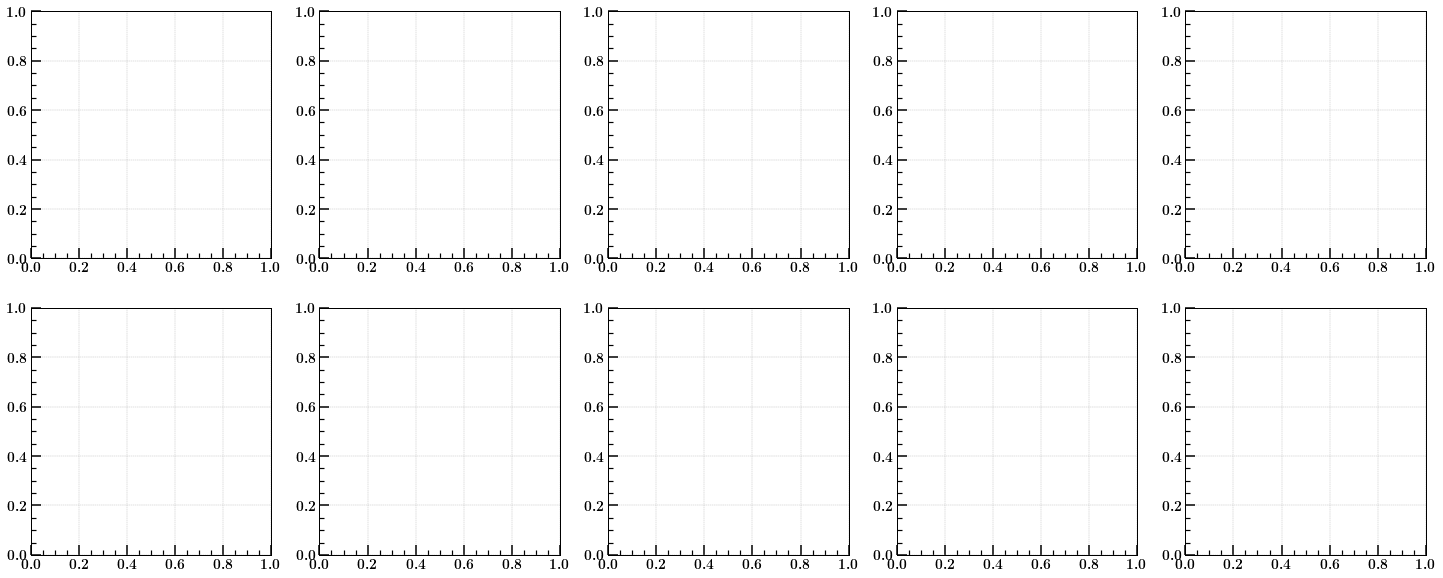

In [32]:
db = connect('bulk.db')
for m_idx in range(0, len(metals)):
    for f in functionals:
        fh = str(m_idx) + "_" + f
        MyEOSFitting(metals[m_idx],db,fh,f)

0_optB88-vdw+FermiDirac+MP.traj
301.12848224028363 GPa
0_optB86B-vdw+FermiDirac+MP.traj
313.7625427978689 GPa
0_optPBE-vdw+FermiDirac+MP.traj
296.7151909452618 GPa
0_rVV10+FermiDirac+MP.traj
567.8760437334835 GPa
0_PBE+D3+FermiDirac+MP.traj
559.8768140639412 GPa
1_optB88-vdw+FermiDirac+MP.traj
298.64964552882554 GPa
1_optB86B-vdw+FermiDirac+MP.traj
311.65097423266036 GPa
1_optPBE-vdw+FermiDirac+MP.traj
294.3682054071788 GPa
1_rVV10+FermiDirac+MP.traj
311.83460257526184 GPa
1_PBE+D3+FermiDirac+MP.traj
337.8233071775203 GPa


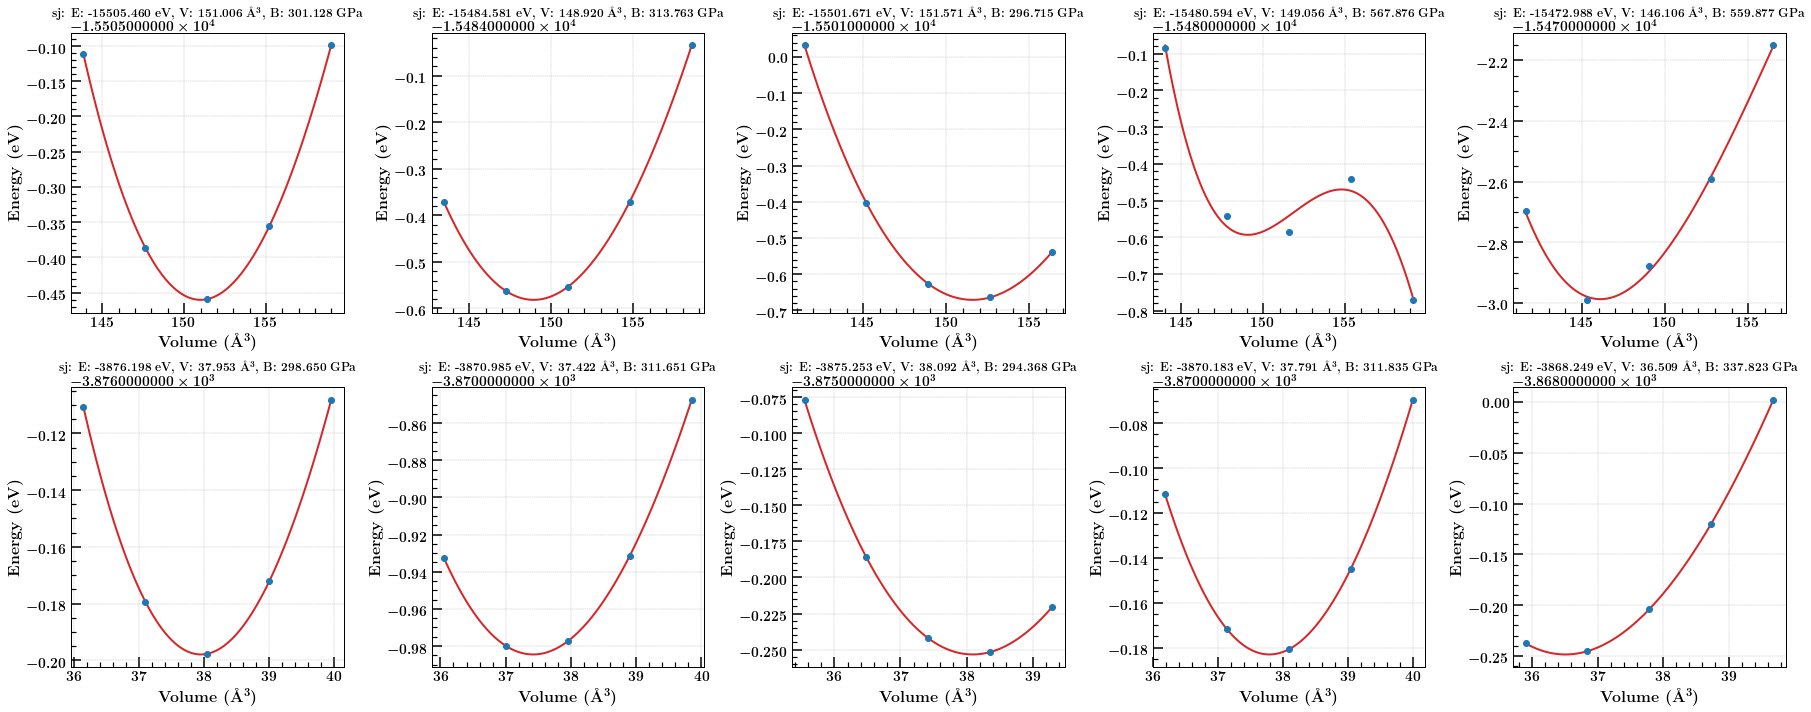

In [35]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))
for m_idx in range(0, len(metals)):
    for f_idx in range(0, len(functionals)):
        
        m = str(m_idx)
        f = functionals[f_idx]
        
        fh = str(m_idx) + "_" + f
        file = fh+".traj"
        configs = Trajectory(file)
        
        # Extract volumes and energies:
        volumes = [a.get_volume() for a in configs]
        energies = [a.get_potential_energy() for a in configs]
        eos = EquationOfState(volumes, energies)
        v0, e0, B = eos.fit()
        
        print(file)
        print(B / kJ * 1.0e24, 'GPa')
        eos.plot(ax=ax[m_idx][f_idx],show=False)
        
plt.tight_layout()
plt.savefig("eos.png")
plt.show()


## Surface Energies

In [69]:

miller_indices = [(0,0,1), (1,0,1), (1,2,1), (1,2,0), (0,0,2)]

# We have the energy of the relaxed structure for each functional in the bulk db
db1 = connect('bulk.db')
db2 = connect('surface.db')

functionals = ["optB88-vdw", 
               "optB86B-vdw",
               "optPBE-vdw",
               "rVV10",
              "PBE+D3"]

for f in functionals:
    for row in db1.select(xcfunctional=f+"+FermiDirac+MP"):
        uc = row.toatoms()
        uc_formula = uc.get_chemical_formula()
        
        if uc_formula == "C4Mo8":
            phase = "alpha"
        if uc_formula == "CMo2":
            phase = "beta"
            
        # Get the Bulk Energy and Formula from the database
        e_bulk = atoms.get_potential_energy()
        uc_symbols = uc.get_chemical_symbols()
        # Create the Surface
        unit_surface = surface(atoms, indices=miller_indices[0], layers=2, vacuum=5)

        unit_surface = sort(unit_surface, unit_surface.positions[:,2])

        c = FixAtoms(indices=[atom.index for atom in unit_surface if atom.position[2] < 0.5*np.sum(unit_surface.get_cell()[:,2])])
        unit_surface.set_constraint(c)
        unit_surface.calc = myCP2KCalculator(f+"+FermiDirac+MP+Surface", 400.0)
        
        #Figure out how many unitcells make up this surface
        unit_surface_symbols = unit_surface.get_chemical_symbols()
        n_uc = len(unit_surface_symbols) // len(uc_symbols)
        
        #Get the Surface Area 
        surface_area = np.linalg.norm(np.cross(unit_surface.get_cell()[0], unit_surface.get_cell()[1]))
        
        '''
        #Do one SCF cycle to get the unrelaxed structure
        e_surface_unrelaxed = unit_surface.get_potential_energy()
        #Minimize the surface to get the relaxed structure
        minimizer = FIRE(unit_surface, trajectory="fire.traj", logfile="fire.log")
        minimizer.run(fmax=0.03)
        e_surface_relaxed = atoms.get_potential_energy()
        #calculate surface enrgy
        e_cleavage = 0.5*(e_surface_unrelaxed - n_uc*e_bulk)
        e_relaxation = e_surface_relaxed - e_surface_unrelaxed
        surface_energy = (e_cleavage + e_relaxation)/surface_area
        '''
